### Preface: this study is stage 4 in the development of a project on cryptocurrencies and step 1 in portfolio modeling.

import required libs

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

from scipy.stats import norm
from scipy.interpolate import interp1d

import plotly.io as pio
import plotly.graph_objs as go
from simple_colors import *

In [2]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Upload the data using the functions from the first stage

In [3]:
interesting_tickers = ['BTC-USD']  # Fidelity Nasdaq Composite Index ETF (ONEQ); Fidelity Limited Term Bond ETF (FLTB)
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='101mo', interval='1mo')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    funds_0 = pd.DataFrame(full_ticker_data)
    funds = pd.DataFrame(funds_0.iloc[:,1:].pct_change(axis='columns'))
    funds.insert(0, "shortName", funds_0.shortName)
    funds.to_csv("BTC-100months (int=1mo).csv") #FLTB.csv, ONEQ.csv

else:
    FLBX = pd.read_csv('FLTB.csv').iloc[:,[0,4]]
    ONEQ = pd.read_csv('ONEQ.csv').iloc[:,[0,4]]
    funds = pd.read_csv('BTC-100months (int=1mo).csv')

# Method Historical Simulation

Data preparation

In [4]:
FLBX_prepared = pd.DataFrame(columns=FLBX.Date)
FLBX_prepared.loc[len(FLBX_prepared)] = list(FLBX.Close)
FLBX_prepared = FLBX_prepared.pct_change(axis='columns').iloc[:,1:-1]
FLBX_prepared.insert(0, "shortName", 'FLBX')

ONEQ_prepared = pd.DataFrame(columns=ONEQ.Date)
ONEQ_prepared.loc[len(ONEQ_prepared)] = list(ONEQ.Close)
ONEQ_prepared = ONEQ_prepared.pct_change(axis='columns').iloc[:,1:-1]
ONEQ_prepared.insert(0, "shortName", 'ONEQ')

funds_ = ONEQ_prepared.merge(FLBX_prepared, how='outer')
funds_.head()

Date shortName  2014-12-01  2015-01-01  2015-02-01  2015-03-01  2015-04-01  \
0         ONEQ   -0.014691   -0.019324    0.072287   -0.014025     0.00732   
1         FLBX   -0.003185    0.008788   -0.007325    0.005584     0.00238   

Date  2015-05-01  2015-06-01  2015-07-01  2015-08-01  ...  2022-05-01  \
0       0.029789   -0.017467    0.029289   -0.068541  ...   -0.019095   
1      -0.000989   -0.003565   -0.002783   -0.001196  ...    0.004463   

Date  2022-06-01  2022-07-01  2022-08-01  2022-09-01  2022-10-01  2022-11-01  \
0      -0.086966    0.125145   -0.045932   -0.105354    0.040299    0.044305   
1      -0.012092    0.011234   -0.014622   -0.019044   -0.006345    0.015562   

Date  2022-12-01  2023-01-01  2023-02-01  
0      -0.089960    0.107640    0.000881  
1      -0.001249    0.012091   -0.010093  

[2 rows x 100 columns]

In [5]:
funds = funds.iloc[:,3:]  # 'cause need the data stars with 2014-12-01
interesting_tickers = ['BTC-USD']
funds.insert(0, "shortName", interesting_tickers)
funds = funds.iloc[:,:-2] 

funds.head()

shortName  2014-12-01 00:00:00+00:00  2015-01-01 00:00:00+00:00  \
0   BTC-USD                  -0.153034                  -0.320835   

   2015-02-01 00:00:00+00:00  2015-03-01 00:00:00+00:00  \
0                   0.169219                  -0.039483   

   2015-04-01 00:00:00+00:00  2015-05-01 00:00:00+00:00  \
0                   -0.03308                  -0.025218   

   2015-06-01 00:00:00+00:00  2015-07-01 00:00:00+00:00  \
0                   0.142847                   0.082023   

   2015-08-01 00:00:00+00:00  ...  2022-05-01 00:00:00+00:00  \
0                  -0.191793  ...                  -0.157035   

   2022-06-01 00:00:00+00:00  2022-07-01 00:00:00+00:00  \
0                  -0.377688                   0.179541   

   2022-08-01 00:00:00+00:00  2022-09-01 00:00:00+00:00  \
0                  -0.140856                  -0.030822   

   2022-10-01 00:00:00+00:00  2022-11-01 00:00:00+00:00  \
0                   0.054755                  -0.162336   

   2022-12-01 00:00:00+00:00  2023-01-01 00:00:00+00:00  \
0                  -0.036175                   0.398356   

   2023-02-01 00:00:00+00:00  
0                   0.000349  

[1 rows x 100 columns]

In [6]:
df_1 = funds_
funds.columns = [str(i).partition(' ')[0] for i in funds.columns]

funds_.columns = [str(i).partition(' ')[0] for i in funds_.columns]
merge_portfolio = funds.merge(funds_, how='outer')
merge_portfolio.head()

shortName  2014-12-01  2015-01-01  2015-02-01  2015-03-01  2015-04-01  \
0   BTC-USD   -0.153034   -0.320835    0.169219   -0.039483    -0.03308   
1      ONEQ   -0.014691   -0.019324    0.072287   -0.014025     0.00732   
2      FLBX   -0.003185    0.008788   -0.007325    0.005584     0.00238   

   2015-05-01  2015-06-01  2015-07-01  2015-08-01  ...  2022-05-01  \
0   -0.025218    0.142847    0.082023   -0.191793  ...   -0.157035   
1    0.029789   -0.017467    0.029289   -0.068541  ...   -0.019095   
2   -0.000989   -0.003565   -0.002783   -0.001196  ...    0.004463   

   2022-06-01  2022-07-01  2022-08-01  2022-09-01  2022-10-01  2022-11-01  \
0   -0.377688    0.179541   -0.140856   -0.030822    0.054755   -0.162336   
1   -0.086966    0.125145   -0.045932   -0.105354    0.040299    0.044305   
2   -0.012092    0.011234   -0.014622   -0.019044   -0.006345    0.015562   

   2022-12-01  2023-01-01  2023-02-01  
0   -0.036175    0.398356    0.000349  
1   -0.089960    0.107640    0.000881  
2   -0.001249    0.012091   -0.010093  

[3 rows x 100 columns]

In [7]:
df_1.index = df_1.shortName
df_1.drop(columns='shortName', inplace = True)

merge_portfolio.index = merge_portfolio.shortName
merge_portfolio.drop(columns='shortName', inplace=True)

# Basic functions for calculating an asset's revenue and its risk

In [8]:
def revenue_for_each_asset(df):
    rev_for_current_asset = 1
    list_of_rev = []
    otv_ = []
    for i in range(len(df.index)):
        
        for j in range(1,len(df.columns)):
            rev_for_current_asset *= (1 + df.iloc[i,j])
        
        list_of_rev.append(rev_for_current_asset)
        rev_for_current_asset = 1
    
    for i in range(len(list_of_rev)):
        if len(df) == 2:
            if i == 0:
                otv_.append((list_of_rev[i]-1)*70)  #вес в % (70% - assets/30% - bonds)
            elif i ==1:
                otv_.append((list_of_rev[i]-1)*30)
        else:
            if i == 0:
                otv_.append((list_of_rev[i]-1)*1)  #вес в % (70% - assets/30% - bonds)
            elif i ==1:
                otv_.append((list_of_rev[i]-1)*69)
            else:
                otv_.append((list_of_rev[i]-1)*30)

    return sum(otv_)


def VaR(cluster):
    if len(cluster.columns) == 2:
        weights = np.array([0.7, .3])           # weights are selected according to Buffett Rule (70-share; 30-bond)
    else:
        weights = np.array([0.01, 0.69, 0.30])  # Why only 1% BTC? This is one of the main conclusions, 
                                                 # if you add at least 1% cryptocurrency to your portfolio, you can
                                                  # achieve not only increased revenue in LR, but also reduce your risks.
    initial_investment = 1000000                  
    cov_matrix = cluster.cov()
    avg_rets = cluster.mean()
    port_mean = avg_rets.dot(weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    mean_investment = (1+port_mean) * initial_investment
    
    stdev_investment = initial_investment * port_stdev
    
    conf_level1 = 0.05

    cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
    
    var_1d1 = initial_investment - cutoff1
    
    return (var_1d1/1000000)*100


## Historical simulation method: we take completely random time intervals and calculate Risk and Revenue for two portfolios: with and without cryptocurrency
In order to make the calculations as accurate as possible, 15000 simulations were used (but according to the law of large numbers from probability theory, we can say that 7500-10000 simulations would be enough).

In [9]:
simulation_of_Carlo = pd.DataFrame(columns=['Rev_no_crypto', 'Risk_no_crypto', 'Rev_crypto', 'Risk_crypto', 'Dimension'])
length_of_df = len(merge_portfolio.columns)
for i in range(15000):
    #dimension = int(np.random.randint(len(merge_portfolio.columns), size=1))
    # Minimum length 2 (second arg in rd.sample (low=2)) to see the change in revenue so that risk can be calculated
    dimension = rd.sample(range(1, length_of_df), int(np.random.randint(low=2, high=len(merge_portfolio.columns)-1, size=1))) 
    #print(dimension)
    rev_no_crypto = revenue_for_each_asset(df_1.iloc[:,dimension])
    Var_no_crypto = VaR(df_1.iloc[:,dimension].T)
    rev_crypto = revenue_for_each_asset(merge_portfolio.iloc[:,dimension])
    Var_crypto = VaR(merge_portfolio.iloc[:,dimension].T)
    simulation_of_Carlo.loc[len(simulation_of_Carlo)] = [rev_no_crypto, Var_no_crypto, rev_crypto, Var_crypto, dimension]

simulation_of_Carlo

Rev_no_crypto  Risk_no_crypto  Rev_crypto  Risk_crypto  \
0         114.955200        5.405539  158.763401     5.398561   
1          15.361751        6.662449   26.819380     6.663920   
2         111.866610        5.456079  205.504293     5.410361   
3          21.877053        5.960850   25.493081     5.988677   
4         110.093964        5.744157  150.671619     5.757348   
...              ...             ...         ...          ...   
14995      37.032943        5.944044   53.495911     5.944173   
14996     152.893138        5.218904  246.075549     5.199456   
14997      71.582348        5.808837  141.193509     5.803783   
14998     101.854041        5.547120  138.830276     5.545391   
14999      16.964611        6.230487   31.199156     6.173351   

                                               Dimension  
0      [25, 15, 93, 89, 59, 23, 39, 48, 67, 69, 3, 14...  
1      [85, 60, 47, 89, 43, 96, 12, 38, 40, 34, 69, 6...  
2      [50, 28, 21, 73, 65, 78, 18, 53, 94, 75, 12, 2...  
3      [1, 37, 42, 26, 19, 39, 96, 54, 86, 76, 14, 94...  
4      [81, 10, 83, 18, 70, 7, 75, 94, 74, 65, 17, 57...  
...                                                  ...  
14995  [33, 59, 41, 42, 36, 97, 6, 63, 71, 37, 45, 87...  
14996  [38, 66, 89, 86, 65, 7, 53, 74, 43, 21, 15, 80...  
14997  [78, 20, 76, 16, 59, 82, 56, 1, 28, 74, 94, 31...  
14998  [10, 78, 39, 70, 52, 31, 95, 15, 76, 33, 59, 6...  
14999  [55, 69, 43, 30, 95, 14, 21, 53, 28, 19, 48, 1...  

[15000 rows x 5 columns]

Share of risk outperformance of a portfolio with crypto relative to a portfolio without crypto (important finding)

In [10]:
len(simulation_of_Carlo[simulation_of_Carlo.Risk_crypto > simulation_of_Carlo.Risk_no_crypto])/len(simulation_of_Carlo) * 100

38.166666666666664

### Only in 38.55% of the cases does the portfolio with cryptocurrency exceed the risk of the portfolio without bitcoin.

Let's distribute the results according to the length of the period considered (how many months were included in the sample): more than 6 years - LR; more than 1 year and less than 6 years - MD; less than 1 year - SR.

In [11]:
simulation_of_Carlo['Period'] = [len(i) for i in simulation_of_Carlo.Dimension]
simulation_of_Carlo.drop(columns='Dimension', inplace=True)

#simulation_of_Carlo.head()

name_of_period = []
for i in simulation_of_Carlo.Period:
    if i >= 72:  # more than 6 year
        name_of_period.append(2)
    elif 12<i<72:
        name_of_period.append(1)
    else:
        name_of_period.append(0)

simulation_of_Carlo['name_of_period'] = name_of_period  #2-LR; 1-MiddleR; 0-SR.
simulation_of_Carlo.drop(columns='Period', inplace=True)
simulation_of_Carlo.head()

Rev_no_crypto  Risk_no_crypto  Rev_crypto  Risk_crypto  name_of_period
0     114.955200        5.405539  158.763401     5.398561               2
1      15.361751        6.662449   26.819380     6.663920               1
2     111.866610        5.456079  205.504293     5.410361               2
3      21.877053        5.960850   25.493081     5.988677               1
4     110.093964        5.744157  150.671619     5.757348               2

### Visualise the distribution of risk and return using a conventional scatter plot and a box plot

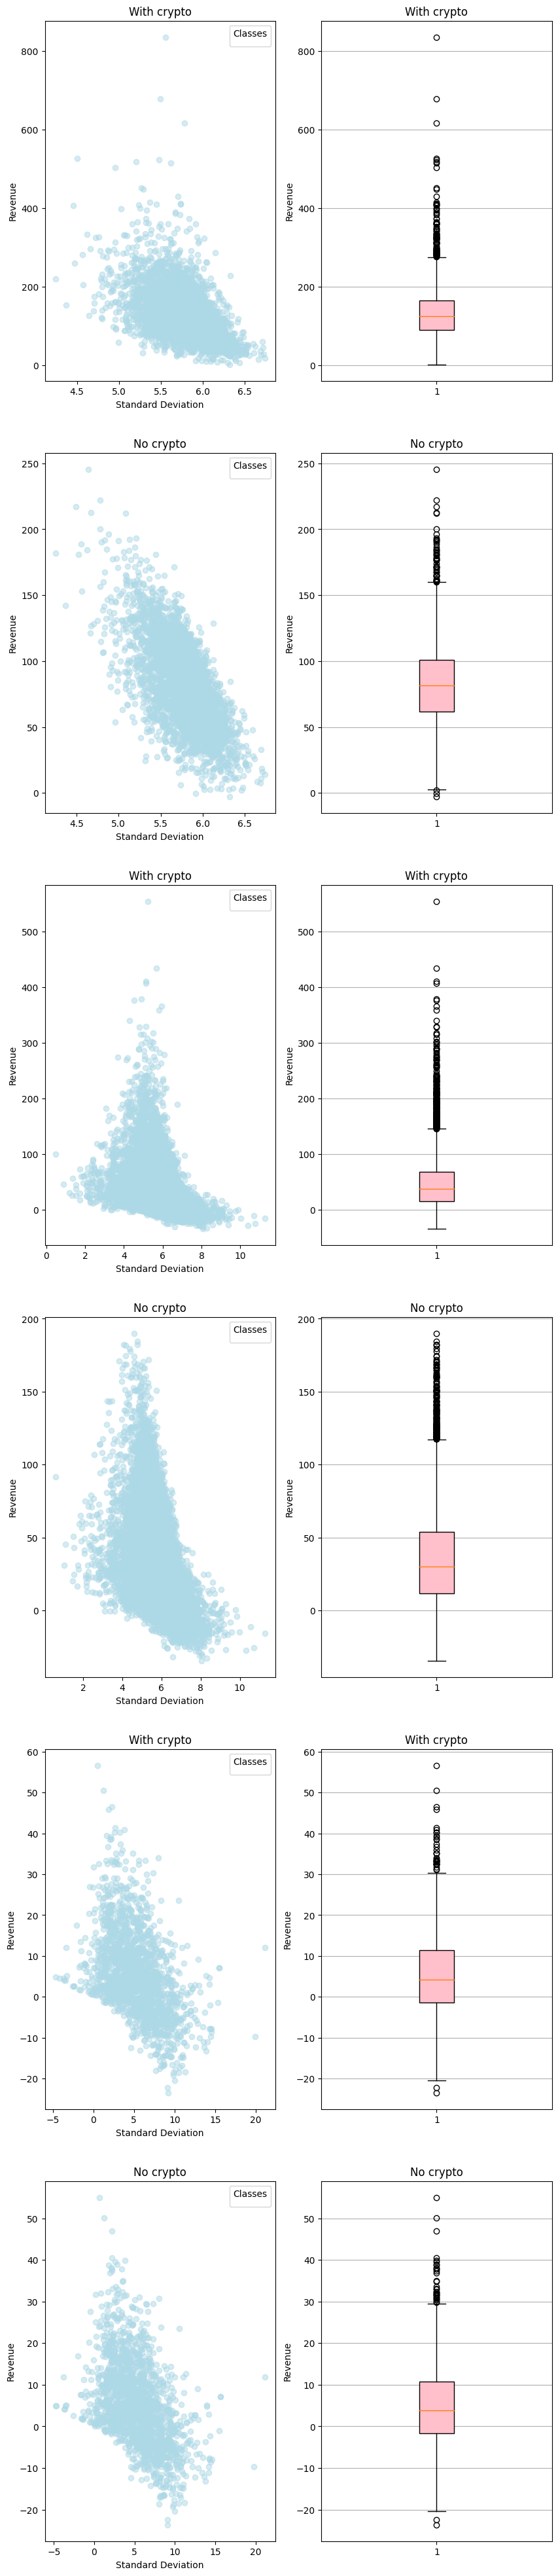

In [12]:
fig, ax = plt.subplots(6,2,figsize=(10, 50))

#LR
LR_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 2]
scatter = ax[0,0].scatter(LR_portfolio_simulation_of_Carlo.Risk_crypto, LR_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[0,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[0,0].set_xlabel('Standard Deviation')
ax[0,0].set_ylabel('Revenue')
ax[0][0].set_title('With crypto')
ax[0][1].set_title('With crypto')
bplot1LR = ax[0,1].boxplot(LR_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[0,1].set_ylabel('Revenue')
ax[0,1].yaxis.grid(True)

scatter = ax[1,0].scatter(LR_portfolio_simulation_of_Carlo.Risk_no_crypto, LR_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[1,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[1,0].set_xlabel('Standard Deviation')
ax[1,0].set_ylabel('Revenue')
bplot2LR = ax[1,1].boxplot(LR_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[1,1].set_ylabel('Revenue')
ax[1][0].set_title('No crypto')
ax[1][1].set_title('No crypto')
ax[1,1].yaxis.grid(True)

#MR
Middle_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 1]
scatter = ax[2,0].scatter(Middle_portfolio_simulation_of_Carlo.Risk_crypto, Middle_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[2,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[2,0].set_xlabel('Standard Deviation')
ax[2,0].set_ylabel('Revenue')
ax[2][0].set_title('With crypto')
ax[2][1].set_title('With crypto')
bplot1Md = ax[2,1].boxplot(Middle_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[2,1].set_ylabel('Revenue')
ax[2,1].yaxis.grid(True)

scatter = ax[3,0].scatter(Middle_portfolio_simulation_of_Carlo.Risk_no_crypto, Middle_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[3,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[3,0].set_xlabel('Standard Deviation')
ax[3,0].set_ylabel('Revenue')
bplot2Md = ax[3,1].boxplot(Middle_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[3,1].set_ylabel('Revenue')
ax[3][0].set_title('No crypto')
ax[3][1].set_title('No crypto')
ax[3,1].yaxis.grid(True)

#SR
SR_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 0]
scatter = ax[4,0].scatter(SR_portfolio_simulation_of_Carlo.Risk_crypto, SR_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[4,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[4,0].set_xlabel('Standard Deviation')
ax[4,0].set_ylabel('Revenue')
ax[4][0].set_title('With crypto')
ax[4][1].set_title('With crypto')
bplot1SR = ax[4,1].boxplot(SR_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[4,1].set_ylabel('Revenue')
ax[4,1].yaxis.grid(True)

scatter = ax[5,0].scatter(SR_portfolio_simulation_of_Carlo.Risk_no_crypto, SR_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[5,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[5,0].set_xlabel('Standard Deviation')
ax[5,0].set_ylabel('Revenue')
bplot2SR = ax[5,1].boxplot(SR_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[5,1].set_ylabel('Revenue')
ax[5][0].set_title('No crypto')
ax[5][1].set_title('No crypto')
ax[5,1].yaxis.grid(True)



colors = ['pink']
for bplot in (bplot1LR, bplot2LR, bplot1Md, bplot2Md, bplot1SR, bplot2SR):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show();

### For the sake of clarity, a general graph of the relationship between revenue and risk has been prepared for all periods

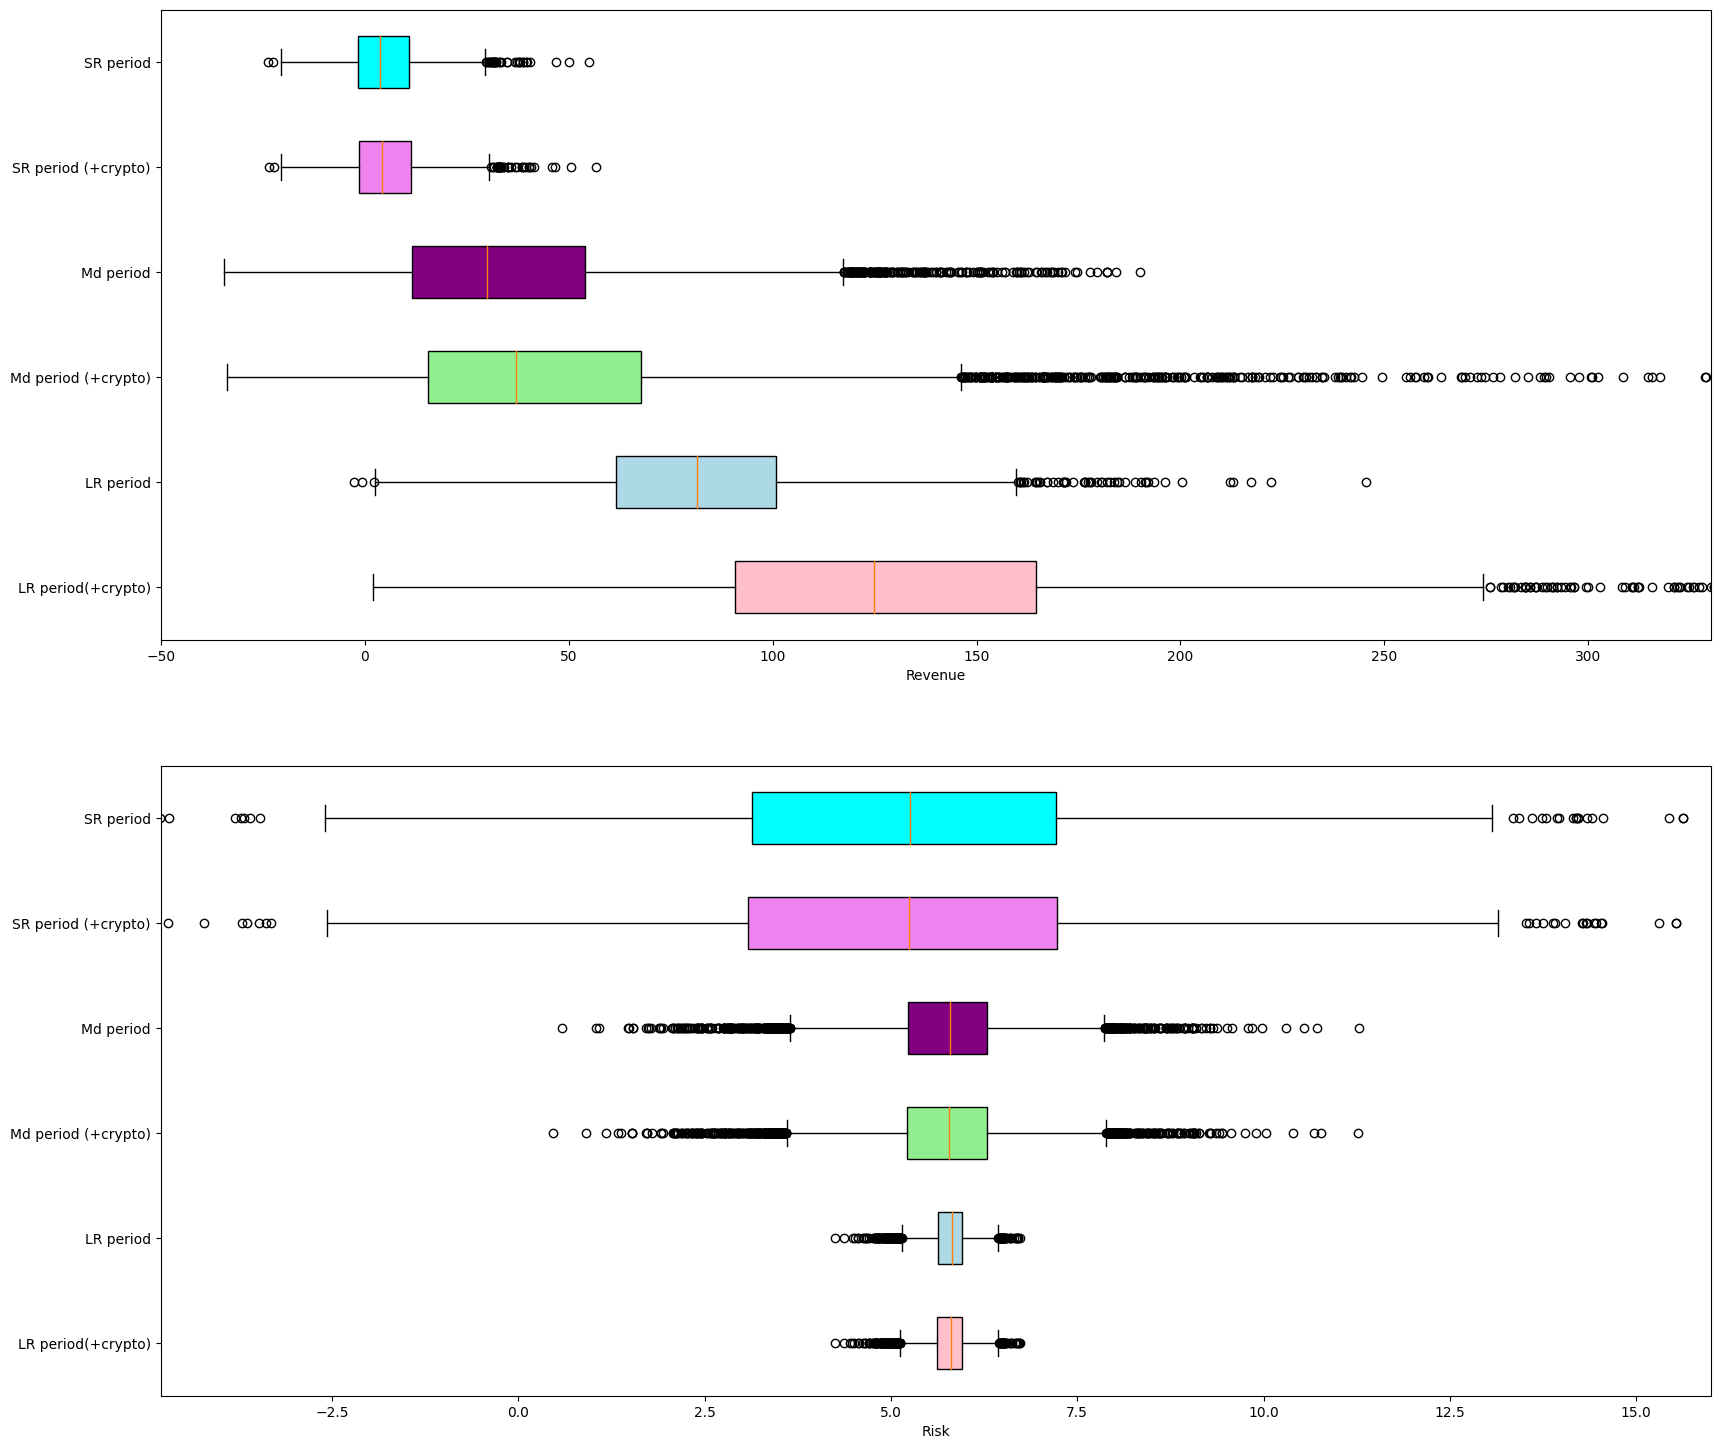

In [14]:
fig, ax = plt.subplots(2,1, figsize=(20, 18))
labels = ['LR period(+crypto)', 'LR period', 'Md period (+crypto)', 'Md period', 'SR period (+crypto)', 'SR period']


bplot_general = ax[0].boxplot([LR_portfolio_simulation_of_Carlo.Rev_crypto, LR_portfolio_simulation_of_Carlo.Rev_no_crypto,
                            Middle_portfolio_simulation_of_Carlo.Rev_crypto, Middle_portfolio_simulation_of_Carlo.Rev_no_crypto,
                            SR_portfolio_simulation_of_Carlo.Rev_crypto, SR_portfolio_simulation_of_Carlo.Rev_no_crypto], 
                           vert=False, patch_artist=True, labels=labels)

bplot_general_2 = ax[1].boxplot([LR_portfolio_simulation_of_Carlo.Risk_crypto, LR_portfolio_simulation_of_Carlo.Risk_no_crypto,
                            Middle_portfolio_simulation_of_Carlo.Risk_crypto, Middle_portfolio_simulation_of_Carlo.Risk_no_crypto,
                            SR_portfolio_simulation_of_Carlo.Risk_crypto, SR_portfolio_simulation_of_Carlo.Risk_no_crypto], 
                           vert=False, patch_artist=True, labels=labels)

ax[0].set_xlabel('Revenue')
ax[1].set_xlabel('Risk')

ax[0].set_xlim([-50,330])
ax[1].set_xlim([-4.8, 16])
colors = ['pink', 'lightblue', 'lightgreen', 'purple', 'violet', 'cyan', 'yellow', 'orange']
for bplot in (bplot_general, bplot_general_2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show();

### Max_profit is a function that finds the maximum optional proportion of crypto in a portfolio

In [17]:
def revenue_for_each_asset(df, only_shares_assets_crypto):
    rev_for_current_asset = 1
    list_of_rev = []
    otv_ = []
    
    for i in range(len(df.index)):
        
        for j in range(1,len(df.columns)):
            rev_for_current_asset *= (1 + df.iloc[i,j])
        
        list_of_rev.append(rev_for_current_asset)
        rev_for_current_asset = 1
    if only_shares_assets_crypto == 0:
        for i in range(len(list_of_rev)):
            if i == 0:
                otv_.append((list_of_rev[i]-1)*100)
            else:
                otv_.append((list_of_rev[i]-1)*0)
    elif only_shares_assets_crypto == 1:
        for i in range(len(list_of_rev)):
            if i == 1:
                otv_.append((list_of_rev[i]-1)*100)
            else:
                otv_.append((list_of_rev[i]-1)*0)
    elif only_shares_assets_crypto == 2:
        for i in range(len(list_of_rev)):
            if i == 2:
                otv_.append((list_of_rev[i]-1)*100)
            else:
                otv_.append((list_of_rev[i]-1)*0)
    elif len(df.index) == 2:
        for i in range(len(list_of_rev)):
            if i == 0:
                otv_.append((list_of_rev[i]-1)*70)
            else:
                otv_.append((list_of_rev[i]-1)*30)
    else:
        share_of_crypto = share_of_crypto_for_calculate_Rev()
        for i in range(len(list_of_rev)):
            if i < (len(list_of_rev) - 2):
                otv_.append((list_of_rev[i] - 1) * (share_of_crypto/(len(list_of_rev)-2)))
            elif i == (len(list_of_rev) - 2):  #assets
                otv_.append((list_of_rev[i] - 1) * (70 - share_of_crypto))
            else:  #bonds
                otv_.append((list_of_rev[i] - 1) * 30)

    return sum(otv_)

def VaR(cluster, k, max_weight_crypto_1_shares_0):

    if k == 0:
        if len(cluster.columns) == 2:
            weights = np.array([0.7, .3])
        else:
            share_of_crypto = share_of_crypto_for_calculate_VaR()
            len_of_crypto_array = len(cluster.columns)-2
            weights = np.array([*np.repeat((share_of_crypto/len_of_crypto_array)/100, len_of_crypto_array), (70-share_of_crypto)/100, 0.30])
    else:
        if max_weight_crypto_1_shares_0 == 0:
            weights = np.array([1, 0, 0])  # only crypto
        elif max_weight_crypto_1_shares_0 == 1:
            weights = np.array([0, 1, 0])  # only equity funds
        elif max_weight_crypto_1_shares_0 == 2:
            weights = np.array([0, 0, 1])  # only bond funds
        
        print(weights)
    
    initial_investment = 1000000
    cov_matrix = cluster.cov()
    avg_rets = cluster.mean()
    port_mean = avg_rets.dot(weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    mean_investment = (1+port_mean) * initial_investment
    
    stdev_investment = initial_investment * port_stdev
    
    conf_level1 = 0.05

    cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
    
    var_1d1 = initial_investment - cutoff1
    
    return (var_1d1/1000000)*100


marker_rev = 0
marker_Var = 0
def share_of_crypto_for_calculate_Rev():
    global marker_rev
    marker_rev += 0.01
    return marker_rev
    
def share_of_crypto_for_calculate_VaR():
    global marker_Var
    marker_Var += 0.01
    return marker_Var
    
def Making_Best_Portolio(df_no_crypro, df_with_crypto):

    main_risk = VaR(df_no_crypro.T, 0, max_weight_crypto_1_shares_0=np.NaN)
    main_rev = revenue_for_each_asset(df_no_crypro, only_shares_assets_crypto=np.NaN)
    best_risk = 0
    best_rev = 0
    
    plt.style.use('ggplot')
    fig, ax1 = plt.subplots(3, 1, figsize=(13,35))
    for_best_risk = []
    for_the_rev_visual = []
    
    all_risks_for_the_final_moving_visual = []
    all_rev_for_the_final_moving_visual = []
    
    
    current_Risk = VaR(df_with_crypto.T, 0, max_weight_crypto_1_shares_0=np.NaN)
    for_best_risk.append(current_Risk)
    all_risks_for_the_final_moving_visual.append(current_Risk)
    while current_Risk <= main_risk:
        
        cur_rev = revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=np.NaN)

        if (cur_rev > main_rev) & (cur_rev > best_rev):
            best_rev = cur_rev
        ax1[0].scatter(float(current_Risk), float(best_rev), s=90 ,c='r')
        current_Risk = VaR(df_with_crypto.T, 0, max_weight_crypto_1_shares_0=np.NaN)
        for_best_risk.append(current_Risk)
        for_the_rev_visual.append(best_rev)
        
        all_rev_for_the_final_moving_visual.append(best_rev)
        all_risks_for_the_final_moving_visual.append(current_Risk)
        
    
    all_risks_for_the_final_moving_visual = all_risks_for_the_final_moving_visual[:-1]
    all_risks_for_the_final_moving_visual.append(main_risk)
    all_rev_for_the_final_moving_visual.append(main_rev)
    
    best_risk = for_best_risk[-2]
    for_best_risk = for_best_risk[:-1]
    
    ax1[0].scatter(best_risk, best_rev, s=90, c='g')
    
    ax1[0].set_title('# How the Risk of Portfolio with crypto increases', color='#A52A2A', fontsize=15)
    ax1[0].set_xlabel('Risk (%)', color='#A52A2A', fontsize=15)
    ax1[0].set_ylabel('Revenue (%)', color='#A52A2A', fontsize=15)
    
    # Mixed frame with initial and best params
    frame_with_diff_invest_portfolios = pd.DataFrame([pd.Series([main_rev, main_risk]), pd.Series([best_rev, best_risk]), pd.Series([0, share_of_crypto_for_calculate_Rev() - 1])])  #-1 так как вызывал дополнительный раз счетчик share_of_..Rev()
    frame_with_diff_invest_portfolios.index = ['No_crypto', 'With crypto', 'Share of crypto']
    frame_with_diff_invest_portfolios.columns= ['Revenue', 'Risk']
    
    # Visual
    for z in range(1):
    
        scatter = ax1[1].scatter(round(frame_with_diff_invest_portfolios.iloc[:2,1],3), round(frame_with_diff_invest_portfolios.iloc[:2,0],3), s=90 ,c=['r','g'])
    
        ax1[1].set_xlabel('Risk (%)', color='#A52A2A', fontsize=15)
        ax1[1].set_ylabel('Revenue (%)', color='#A52A2A', fontsize=15)
        ax1[1].set_title('# Manage Portfolio - 70/30 and ' + str(round(frame_with_diff_invest_portfolios.iloc[2,1],3)) + '/' + str(round((70 - frame_with_diff_invest_portfolios.iloc[2,1]),3)) + '/30)', color='#A52A2A', fontsize=15)
    
        for t in range(len(frame_with_diff_invest_portfolios.index) - 1):
            if t == 0:
                ax1[1].text(round(frame_with_diff_invest_portfolios.iloc[t,1] + 0.0002, 3)-1.1, round(frame_with_diff_invest_portfolios.iloc[t,0] + 8, 3)-190, '70% assets & 30% bonds (only Fidelity)', fontsize=8, color='Red')
            elif t == 1:
                ax1[1].text(round(frame_with_diff_invest_portfolios.iloc[t,1] + 0.0002, 3)-0.8, round(frame_with_diff_invest_portfolios.iloc[t,0] + 8, 3)+100, str(round(frame_with_diff_invest_portfolios.iloc[2,1], 3)) + '% Btc ' + str(round((70 - frame_with_diff_invest_portfolios.iloc[2,1]),3)) +'% assets' +' 30% bonds', fontsize=12, color='Green')
        ax1[1].scatter(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=0), revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=0))  # only crypto
        ax1[1].scatter(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=1), revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=1))  # only equity funds
        ax1[1].scatter(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=2), revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=2))  # only bond funds
        
        all_risks_for_the_final_moving_visual.append(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=0))          # add a point (only crypto)
        all_rev_for_the_final_moving_visual.append(revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=0)) # rev- only crypto
        
        all_risks_for_the_final_moving_visual.append(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=1))          # add a point (only crypto)
        all_rev_for_the_final_moving_visual.append(revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=1)) # rev- only equity funds
        
        all_risks_for_the_final_moving_visual.append(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=2))          # add a point (only crypto)
        all_rev_for_the_final_moving_visual.append(revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=2)) # rev- only bond funds
        
        ax1[1].text(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=0)-0.55, revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=0)+55, '100% crypto', c='b', fontsize=15)
        ax1[1].text(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=1)-0.2, revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=1)-150, '100% assets', c='b')
        ax1[1].text(VaR(df_with_crypto.T, 1, max_weight_crypto_1_shares_0=2)-0.45, revenue_for_each_asset(df_with_crypto, only_shares_assets_crypto=2)+100, '100% bonds', c='b')
        
        ax1[1].grid(True)
    
    risk = np.array(for_best_risk)         # risk value array
    revenue = np.array(for_the_rev_visual) # revenue value array

    # Data interpolation
    f = interp1d(risk, revenue, kind='cubic')

    # Control points for the Bézier curve
    p0 = [risk[0], revenue[0]]
    p1 = [risk[len(risk)//2], np.max(revenue)]
    p2 = [risk[-1], revenue[-1]]
    x = [p0[0], p1[0], p2[0]]
    y = [p0[1], p1[1], p2[1]]

    # Bézier curve
    t = np.linspace(0, 1, 100)
    bx = (1-t)**2*x[0] + 2*(1-t)*t*x[1] + t**2*x[2]
    by = (1-t)**2*y[0] + 2*(1-t)*t*y[1] + t**2*y[2]

    # Data and Bézier curve visualisation
    ax1[2].plot(risk, revenue, 'o', label='Data')
    ax1[2].plot(bx, by, '-', label='Bezier curve')
    ax1[2].legend()
    ax1[2].set_title('Increases Risk and Bezier curve ', color='#A52A2A', fontsize=15)
    ax1[2].set_xlabel('Risk (%)', color='#A52A2A', fontsize=15)
    ax1[2].set_ylabel('Revenue (%)', color='#A52A2A', fontsize=15)
    
    pio.renderers.default = 'notebook'

    risk = all_risks_for_the_final_moving_visual
    revenue = all_rev_for_the_final_moving_visual

    ax1 = go.Figure(data=[go.Scatter(x=risk, y=revenue, mode='markers')])
    ax1.show()    
    plt.show()
    
    return frame_with_diff_invest_portfolios
    


[1 0 0]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 0]
[0 0 1]


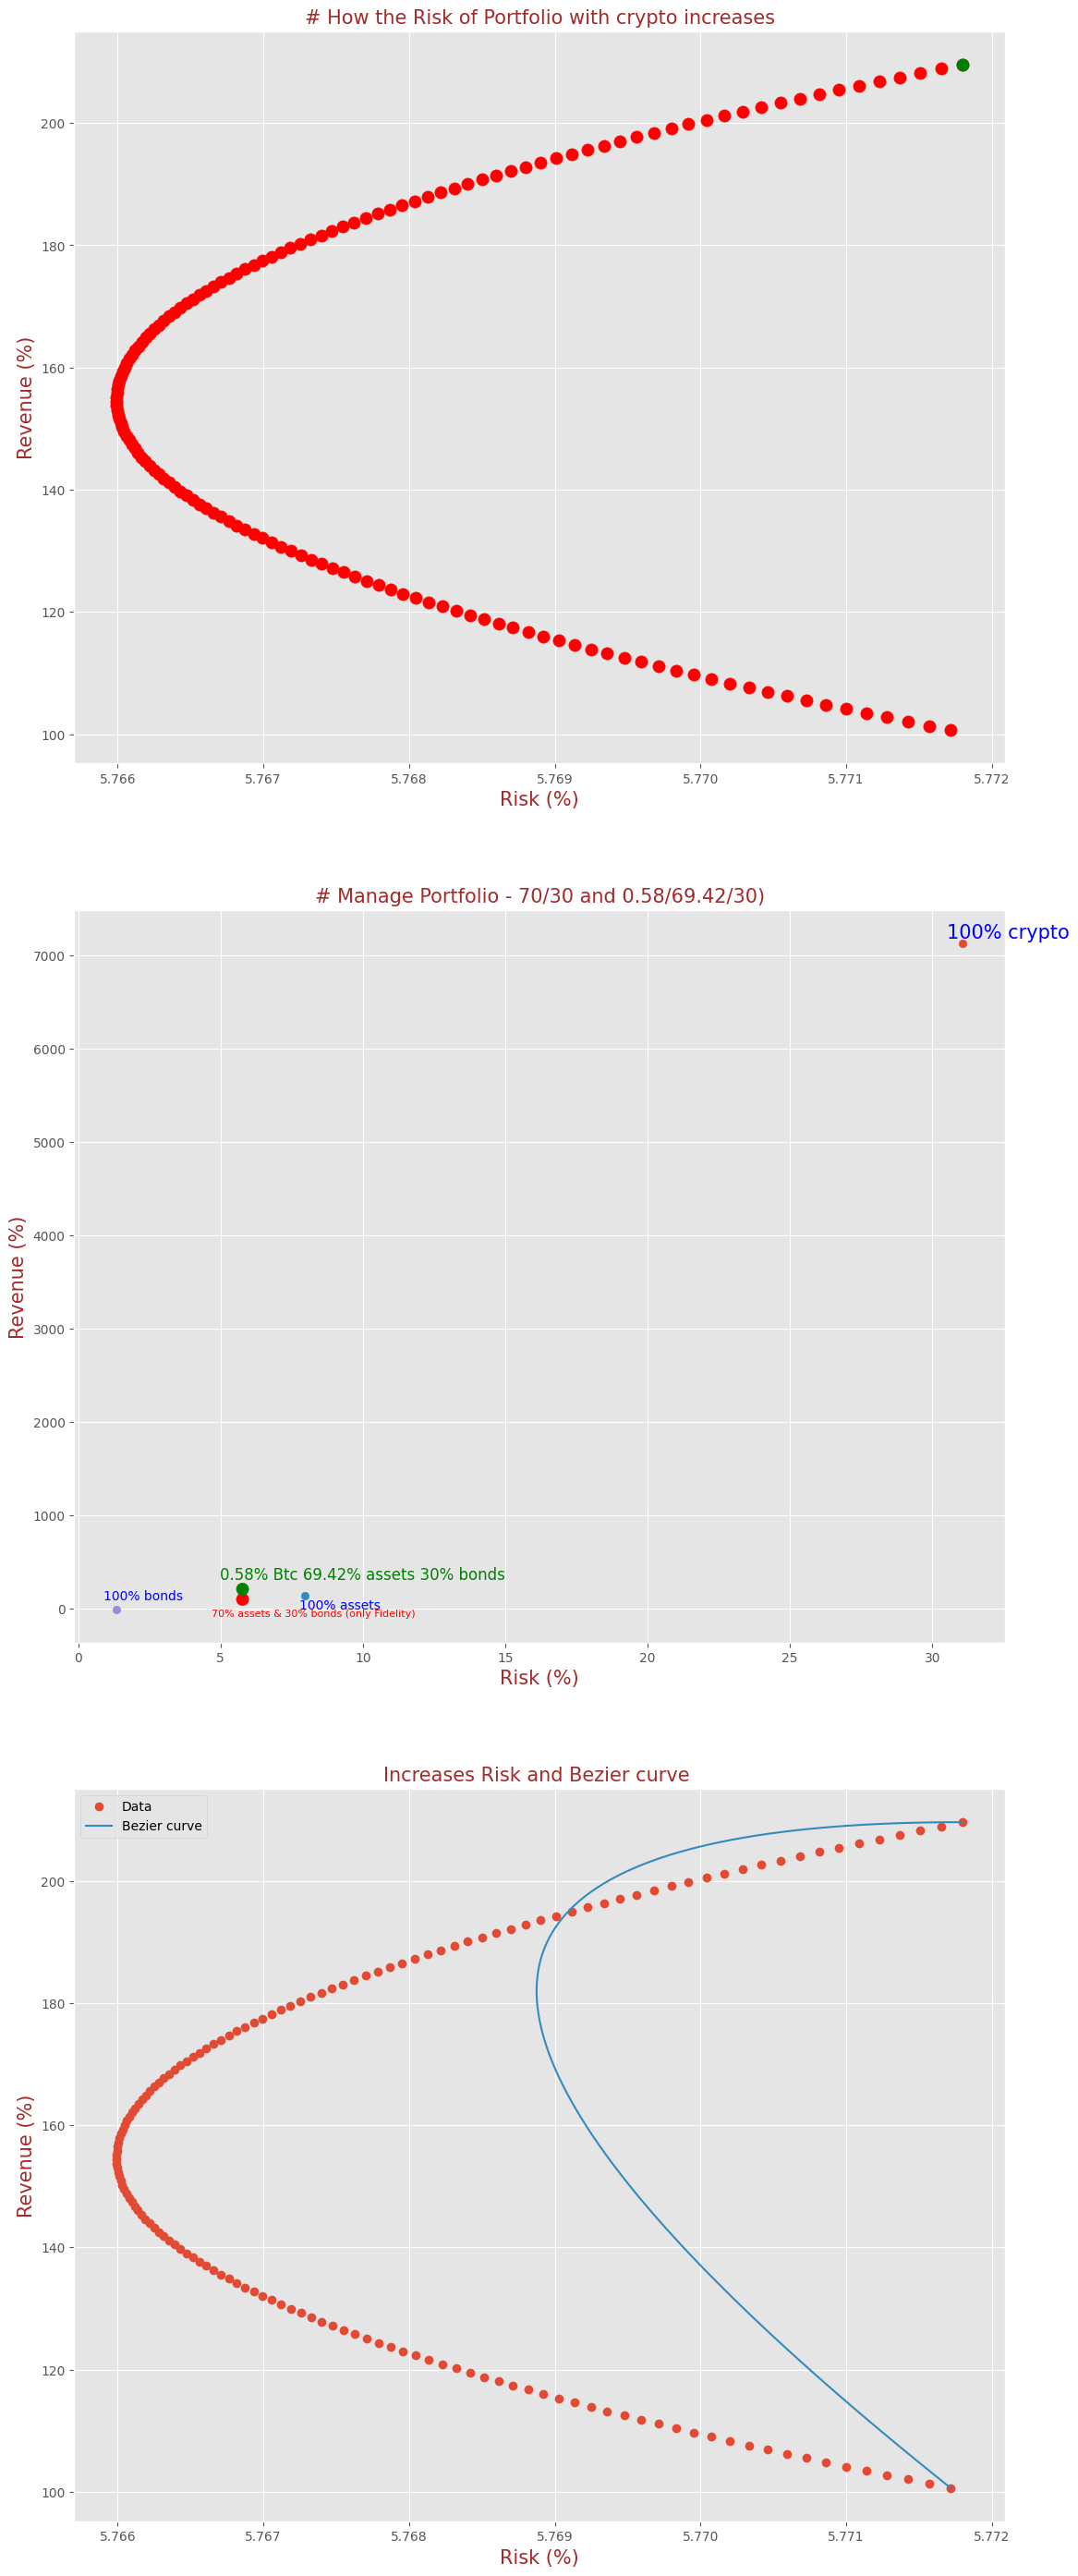

Revenue      Risk
No_crypto         99.933593  5.771867
With crypto      209.593467  5.771800
Share of crypto    0.000000  0.580000

In [18]:
Making_Best_Portolio(df_no_crypro=df_1, df_with_crypto=merge_portfolio)

# Conclusion:

1. In about 2/3 of the cases, a portfolio with crypto will be LESS risky than a portfolio without crypto - it is important to note that this result is obtained REGARDLESS of the period in question! (i.e. 2/3 is not just for LR periods).
- This is an important conclusion that cryptocurrency can diversify an institutional investor's portfolio.

2. Boxplots - allows to visualise the risk and return distribution of two portfolios depending on the period considered. When the difference in return between two portfolios is visible to the eye, it is difficult to see the distribution of risk, but when looking closer, at least at the median, the difference (however small) is visible.
- Moreover, the highest returns and the lowest risk are achieved during periods of long-term investment.

3. The final block of this phase of the research shows the optimal amount of cryptocurrency in the investor's portfolio, which maximises returns by increasing the proportion of BTC at each step until the risk of such a portfolio is < than the risk of a portfolio without crypto. The optimal value was found to be 0.58%.
- Thus, it can be clearly concluded that adding even a small part of cryptocurrency to an institutional investor's portfolio can reduce the portfolio's risks and increase its profit many times over!